In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, PReLU,BatchNormalization, Flatten, UpSampling2D, LeakyReLU, Dense, Input, add
from tensorflow.keras.applications import VGG19
from tqdm import tqdm
from PIL import Image
import random


In [2]:
lr_images_path = '../data/lr_images'
hr_images_path = '../data/hr_images'

In [3]:
lr_filenames = sorted(os.listdir(lr_images_path))[:]
hr_filenames = sorted(os.listdir(hr_images_path))[:]

# Verify that the filenames match
if lr_filenames != hr_filenames:
    raise ValueError("Filenames in lr_images and hr_images do not match!")

In [4]:
lr_images = []
hr_images = []


for img_name in lr_filenames:
    lr_img = Image.open(os.path.join(lr_images_path, img_name))
    hr_img = Image.open(os.path.join(hr_images_path, img_name))
    
    # Convert grayscale images to RGB format
    if lr_img.mode != 'RGB':
        lr_img = lr_img.convert('RGB')
        
    if hr_img.mode != 'RGB':
        hr_img = hr_img.convert('RGB')
    
    lr_img = np.asarray(lr_img)
    hr_img = np.asarray(hr_img)
    
    lr_images.append(lr_img)
    hr_images.append(hr_img)

In [5]:
lr_images_array = np.stack(lr_images)
hr_images_array = np.stack(hr_images)

print("LR Images Array Shape:", lr_images_array.shape)
print("HR Images Array Shape:", hr_images_array.shape)

LR Images Array Shape: (15129, 64, 64, 3)
HR Images Array Shape: (15129, 128, 128, 3)


In [6]:
# Split the data into training, validation, and test sets
random_seed = 42 

train_lr_images, val_test_lr_images, train_hr_images, val_test_hr_images = train_test_split(
    lr_images_array, hr_images_array, test_size=0.3, random_state=random_seed
)

val_lr_images, test_lr_images, val_hr_images, test_hr_images = train_test_split(
    val_test_lr_images, val_test_hr_images, test_size=0.5, random_state=random_seed
)

In [7]:
def normalize(x):
    return x / 255.0

def denormalize(x):
    return (x + 1) * 127.5

def pixel_shuffle(scale):
    return lambda x : tf.nn.depth_to_space(x, scale)

def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size = 3, padding = 'same')(x_in)
    x = Lambda(pixel_shuffle(2))(x)
    return PReLU(shared_axes=[1,2])(x)

def residual_block(block_input, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(block_input)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([block_input, x])
    return x

def build_srresnet(num_filters=64, num_res_blocks=16):
    
    num_upsamples = 1

    lr = Input(shape=(64, 64, 3))
    x = Lambda(normalize)(lr)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = residual_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    for _ in range(num_upsamples):
        x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    sr = Lambda(denormalize)(x)


    return Model(lr, sr)

In [8]:
def discriminator_block(x_in, num_filters, strides=1, batchnorm=True, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_in)
    if batchnorm:
        x = BatchNormalization(momentum=momentum)(x)
    return LeakyReLU(alpha=0.2)(x)


def build_discriminator(hr_shape):
    x_in = Input(shape=(hr_shape, hr_shape, 3))
    x = Lambda(normalize)(x_in)

    x = discriminator_block(x, 64, batchnorm=False)
    x = discriminator_block(x, 64, strides=2)

    x = discriminator_block(x, 128)
    x = discriminator_block(x, 128, strides=2)

    x = discriminator_block(x, 256)
    x = discriminator_block(x, 256, strides=2)
    x = Flatten()(x)

    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(x_in, x)



In [9]:
vgg = VGG19(input_shape=(None, None, 3), include_top=False, weights = 'imagenet')
perceptual_model = Model(vgg.input, vgg.layers[20].output)

generator = build_srresnet()

discriminator = build_discriminator(128)


bce = BinaryCrossentropy()
mse = MeanSquaredError()
learning_rate=PiecewiseConstantDecay(boundaries=[100000], values=[1e-4, 1e-5])

gen_optimizer = Adam(learning_rate=learning_rate)
disc_optimizer = Adam(learning_rate=learning_rate)

def psnr_metric(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)

checkpoint_path = '../scratch/lung_SRGAN/checkpoints/'

srgan_checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                       psnr=tf.Variable(0.0),
                                       generator_optimizer=Adam(learning_rate),
                                       discriminator_optimizer=Adam(learning_rate),
                                       generator=generator,
                                       discriminator=discriminator)


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-09-19 16:06:56.966940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-19 16:06:56.967390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 64, 64, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   15616       ['lambda[0][0]']                 
                                                                                                  
 tf.math.negative (TFOpLambda)  (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                            

In [11]:
discriminator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 lambda_3 (Lambda)           (None, 128, 128, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                           

In [41]:
# generator = build_srresnet()
# discriminator = build_discriminator(128)

checkpoint_path = '../lung_SRGAN/checkpoints/'

latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
if latest_checkpoint:
    # Restore the weights
    srgan_checkpoint.restore(latest_checkpoint).assert_consumed()


# model = load_model('/Users/anwesh/code/lung_SRGAN/CT_SRGAN/ckpt_generator.h5')

In [63]:
preds = srgan_checkpoint.generator.predict(test_lr_images)

51/71 [====================>.........] - ETA: 30s

KeyboardInterrupt: 

In [ ]:
preds = preds / 255.0

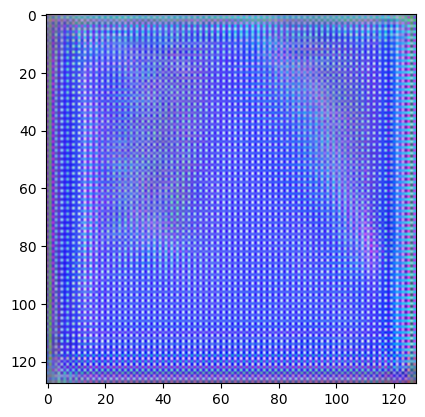

In [ ]:
plt.imshow(preds[4], cmap = 'gray')

In [55]:
def psnr_metric(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)

In [57]:
tf.math.reduce_mean(psnr_metric(preds, val_hr_images))

<tf.Tensor: shape=(), dtype=float32, numpy=3.6042874>